<a href="https://colab.research.google.com/github/nivalf/Automated-Speech-Recognition/blob/main/Automated_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Speech Recognition

The aim of this project is to develop a deep learning system to perform automated speech recognition.


## Details

**Data**
**Input data:** Raw speech has been pre-processed into spectrograms of speech ‘images’ (power vs time vs
frequency). This is the input data (Figure 1). The data is split into training and validation sets (Figure 2).

**Output data:** There are 12 word categories (i.e. 12 classes). This is the output data.

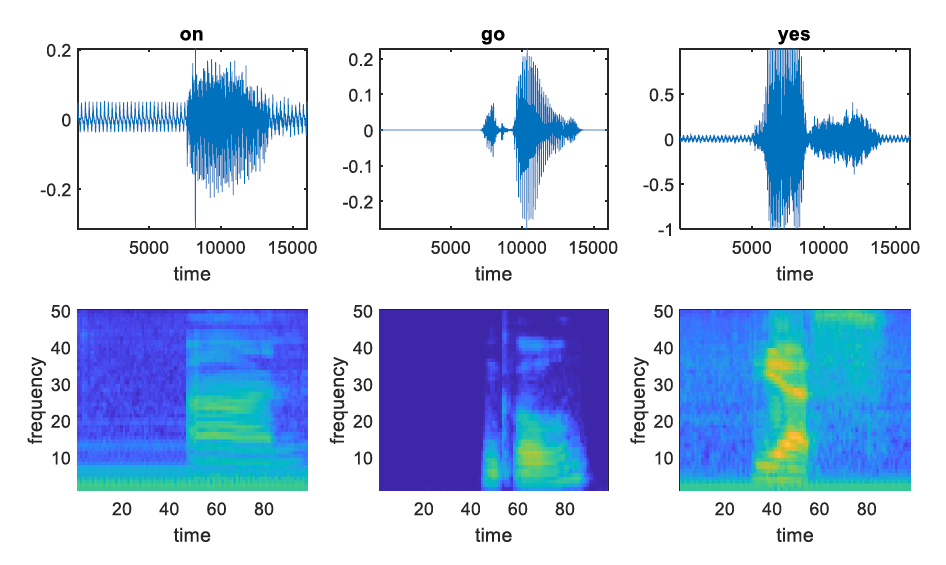

**Figure 1.** Examples of speech waveforms in the time-domain (top) and corresponding speech image
spectrogram that forms the input data (bottom). The spoken word is given in the title and forms the class
label output: ‘on’, ‘go’ and ‘yes’.

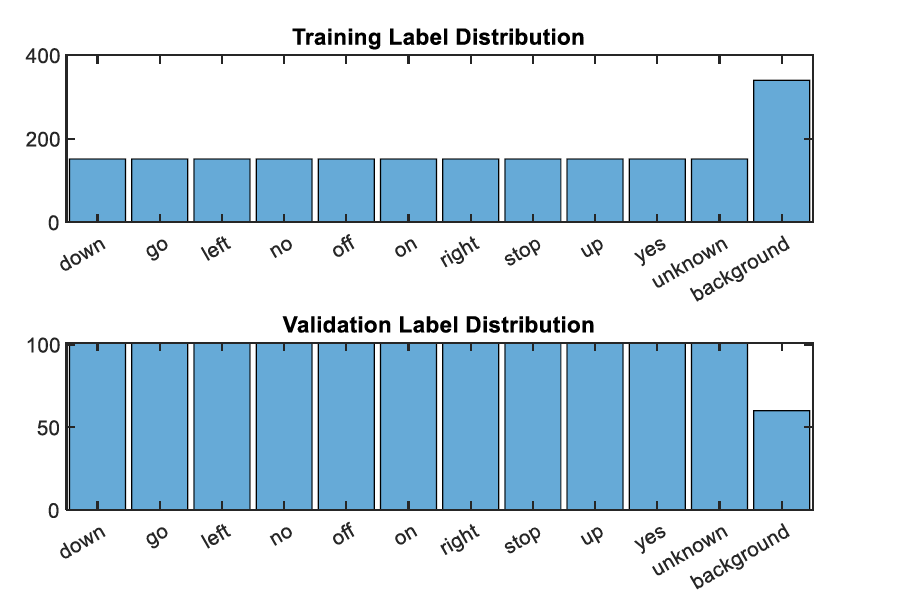


**Figure 2.** The initial training and validation data has the distribution shown in the plots, i.e. 12 words
(therefore 12 classes) and nearly 200 training data pairs per word and 100 validation data pairs per word.


# Libraries and Helpers


### General Libraries

In [57]:
import matplotlib.pyplot as plt

### Helper Functions

In [1]:

import importlib.util
import subprocess

# Install a package if it is not already installed
def install_package(name):
  spec = importlib.util.find_spec(name)
  if spec is None:
    print(f"installing {name} module")
    subprocess.check_call(['pip', 'install', name])
  else:
    print(f"{name} already installed")

#  <> Pre-process the data

The code does the following:

*   Load the data
*   Creates Keras training and validation datasets
*   Extracts input-output data from the Keras datasets
*   Normalise the image data

## Load the data


  *   Pulls the data in from github
  *   Unzips the data

This is done only if the target folder doesn't exist already. When re-running the entire code, this check ensures that no duplicate folder is created.


In [2]:
import tensorflow as tf
import os.path

path = '/content/speechImageData - Copy/TrainData'

if(not os.path.isdir(path)):
  print('Getting data from github and unzipping...')

  # get the data from github and unzip
  !wget https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
  !unzip -q /content/speechImageData.zip

else:
  print("Unzipped folder already exists! (speechImageData - Copy)")


Getting data from github and unzipping...
--2023-03-25 09:29:50--  https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9872924 (9.4M) [application/zip]
Saving to: ‘speechImageData.zip’

speechImageData.zip 100%[===================>]   9.42M  --.-KB/s    in 0.04s   

2023-03-25 09:29:51 (263 MB/s) - ‘speechImageData.zip’ saved [9872924/9872924]



## Pre-process data into training and validation sets, using Keras dataset objects

Note that when the data is unzipped it is stored locally to Google Colab in the content folder and the unzipped folder is called 

'speechImageData - Copy'

and it contains: 

the training data in the folder TrainData and 

the validation in the folder ValData

There are 12 classes of different spoken words and the spectrograms, which form the input image data are of size 98x50 pixels.

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/speechImageData - Copy/TrainData', 
    labels='inferred', 
    color_mode="grayscale", 
    label_mode='categorical', 
    batch_size=128, 
    image_size=(98, 50)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/speechImageData - Copy/ValData', 
    labels='inferred', 
    color_mode="grayscale", 
    label_mode='categorical', 
    batch_size=128, 
    image_size=(98, 50)
)

# Save the number of classes
num_classes = len(train_ds.class_names)

Found 2001 files belonging to 12 classes.
Found 1171 files belonging to 12 classes.


## Extract input-output data, which can be useful for plotting confusion matrices etc.

In [4]:
# Extract the  training input images and output class labels
x_train = []
y_train = []
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

print(y_train)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val = tf.concat(x_val, axis=0)
y_val = tf.concat(y_val, axis=0)

print(y_val)



tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]], shape=(2001, 12), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(1171, 12), dtype=float32)


## Normalise the image data

In [5]:
# Divide by 255 to normalise the data

x_train = x_train/255.0
x_val = x_val/255.0

# <> Model

Requirement: Validation accuracy >= 60%

## 1. Model using grid search



Note that the network design has two convolutional blocks:

Conv --> Batch norm --> ReLU

and a max pooling layer is used for dimension reduction

In [6]:
#@title

import numpy as np
from sklearn.metrics import confusion_matrix     
import seaborn as sns      
from keras.models import Sequential                               
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D, Flatten, Softmax      
from keras import optimizers, regularizers 

In [49]:
#@title
from keras.layers import (Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense) 
from keras.optimizers import Adam 
from sklearn.model_selection import GridSearchCV 
from keras.wrappers.scikit_learn import KerasClassifier 

# function to build the model 
def create_model(num_layers, num_filters): 
  input_shape = (98,50,1)
  time_pool_size = 12

  model = Sequential() 
  model.add(Conv2D(num_filters, kernel_size=(3,3), padding='same', 
                   activation='relu', input_shape=input_shape))
  model.add(BatchNormalization()) 
  # model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')) 

  for i in range(num_layers-1): 
    model.add(Conv2D(num_filters, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization()) 
    if i != num_layers-1:
      model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), padding='same')) 
      model.add(Dropout(0.1))

  # Max pool layer across time dimension
  model.add(MaxPooling2D(pool_size =(time_pool_size, 1), strides=(1, 1), padding= 'same'))

  model.add(Flatten()) 
  model.add(Dense(num_classes, activation='softmax')) 
  model.add(Dropout(0.2))

  # set the optimization options and compile the model
  opt = optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
  return model 
  
# create keras sklearn wrapper 
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32) 

# define the grid search parameters 
param_grid = {
              'num_layers': [5, 6], 
              'num_filters': [32, 64]
              } 

# perform the grid search 
grid = GridSearchCV(estimator=model, param_grid=param_grid, return_train_score=True, verbose=1, cv=2) 

# train_dataset = tf.data.Dataset.from_tensor_slices(x_train, y_train)
grid_result = grid.fit(x_train.numpy(), y_train.numpy())

# Print the summary of the model
# model.summary()

<ipython-input-49-226d5e0c383b>:38: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Epoch 1/20
32/32 [==============================] - 2s 19ms/step - loss: 5.8420 - accuracy: 0.1420
Epoch 2/20
32/32 [==============================] - 0s 14ms/step - loss: 4.7632 - accuracy: 0.2550
Epoch 3/20
32/32 [==============================] - 0s 14ms/step - loss: 4.6942 - accuracy: 0.2790
Epoch 4/20
32/32 [==============================] - 0s 14ms/step - loss: 4.7212 - accuracy: 0.2890
Epoch 5/20
32/32 [==============================] - 0s 14ms/step - loss: 4.5867 - accuracy: 0.3470
Epoch 6/20
32/32 [==============================] - 0s 14ms/step - loss: 4.2862 - accuracy: 0.3810
Epoch 7/20
32/32 [==============================] - 0s 14ms/step - loss: 4.5757 - accuracy: 0.4100
Epoch 8/20
32/32 [==============================] - 0s 14ms/step - loss: 4.4691 - accuracy: 0.4390
Epoch 9/20
32/32 [==============================] - 0s 14ms/step - loss: 4.1077 - accuracy: 0.4490
Epoch 10/20
32/32 [==============================]

In [50]:

# print the best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.719639 using {'num_filters': 64, 'num_layers': 5}


Text(0.5, 1.0, 'Mean test score of Grid Search')

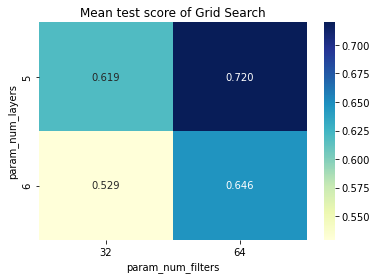

In [58]:
import pandas as pd
import seaborn as sns

# Convert the results to a pandas dataframe
results_df = pd.DataFrame(grid_result.cv_results_)

# Pivot the dataframe to get the mean test scores for each hyperparameter combination
pivot_df = results_df.pivot_table(values='mean_test_score', index='param_num_layers', columns='param_num_filters')

# Create a heatmap of the mean test scores
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title("Mean test score of Grid Search")


Text(0.5, 1.0, 'Test scores vs. training times')

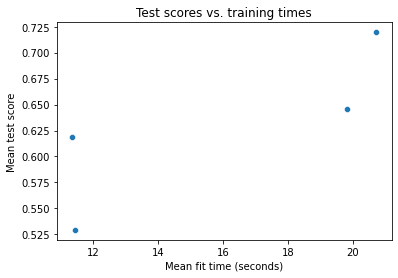

In [59]:

# Scatter plot of test scores vs. mean_fit_time
sns.scatterplot(x='mean_fit_time', y='mean_test_score', data=results_df)
plt.xlabel('Mean fit time (seconds)')
plt.ylabel('Mean test score')
plt.title('Test scores vs. training times')

## 2. Model Details

### 2.1. Keras Plot Model

In [ ]:
#@title
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### 2.2. Visual Keras

In [ ]:
# Install visualkeras & import
install_package('visualkeras')

installing visualkeras module


In [ ]:
#@title
import visualkeras
visualkeras.layered_view(model, legend=True)

AttributeError: ignored

## 3. Train the model

This section trains the deep convolutional network using the Adam algorithm.

### 3.1 Setup Tensorboard

In [ ]:
#@title
%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard

# creating logs that are timestamped.
# Beneficial when using multiple experiments
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Clear current logs
!rm -rf /logs/

# Callback
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]
                         

### 3.2 Train

In [ ]:
#@title
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.1, callbacks=callbacks)


In [ ]:
#@title
%tensorboard --logdir={log_folder}

## 4. Evaluate the model

### 4.1. Plot accuracy and loss over training iterations

Plot accuracy and loss over training epochs (for both training data and validation data) - it is important to monitor convergence of the algorithm via these plots to assess whether the parameter estimation has converged.

In [ ]:


# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("")

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



### 4.2. Print out the accuracy on the Validation Data


In [ ]:
# print out the accuracy on independent test data
score = model.evaluate(x_val, y_val, verbose=0)
print("Test accuracy:", score[1])

### 4.3. Confusion matrix

Calculate and display the confusion matrix for this problem - the confusion matrix is important to inspect because it gives more insight into classifier performance across all classes than simply inspecting accuracy, which obscures detail.

In [ ]:
# obtain model predictions and convert softmax outputs 0-1 to integer class label predictions
Yhat = model.predict(x_val)                    # predict model outputs on validation data as softmax outputs of probability of each class
Yhat_integer = np.argmax(Yhat, axis=1)            # obtain the most likely class prediction as the argument of the max softmax output
Y_test_integer = np.argmax(y_val, axis=1)   # obtain the true class as an integer 

# calculate and plot confusion matrix
cm = confusion_matrix(Y_test_integer, Yhat_integer , normalize="pred")    # calculate the confusion matrix
plt.figure(2).set_figwidth(15)                                            # setup new figure
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap="Blues",)          # plot the confusion matrix using the sns package
plt.title("Confusion Matrix", fontsize = 12)                              # title
plt.xlabel("Predicted Class", fontsize = 12)                              # xlabel
plt.ylabel("True Class", fontsize = 12)                                   # ylabel
plt.show()                                                                # show plot